In [12]:
from copy import deepcopy
import gymnasium as gym
import gym_pusht
from gymnasium.wrappers import RecordVideo
from IPython.display import Video, Image
import matplotlib.pyplot as plt
import numba
import numpy as np
import torch
from tqdm import tqdm

from diffusers import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler

from rl_playground.episodes import *
from rl_playground.utils import *
from rl_playground.diffusion import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
env = gym.make(
    "gym_pusht/PushT-v0", obs_type="pixels_agent_pos", render_mode="rgb_array"
)
env = ScaleRewardWrapper(env)
# record_video(env, horizon=180, name="PushTRandom")

In [3]:
# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8

In [7]:
trajectories = [
    get_rollout(episode_length=i, policy=None, env=env) for i in range(25, 30)
]

dataset = PushTDatasetFromTrajectories(
    trajectories,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon,
    get_original_goal=False,
)

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=False,
)

# visualize data in batch
batch = next(iter(dataloader))
print(
    "batch['image'].shape:", batch["image"].shape
)  # (batch_size, obs_horizon, C, H, W)
print(
    "batch['agent_pos'].shape:", batch["agent_pos"].shape
)  # (batch_size, obs_horizon, 2)
print("batch['action'].shape", batch["action"].shape)  # (batch_size, action_horizon, 2)
print(
    "batch['reached_goal_agent_pos'].shape:", batch["reached_goal_agent_pos"].shape
)  # (batch_size, 2)
print(
    "batch['reached_goal_image'].shape:", batch["reached_goal_image"].shape
)  # (batch_size, C, H, W)

batch['image'].shape: torch.Size([64, 2, 3, 96, 96])
batch['agent_pos'].shape: torch.Size([64, 2, 2])
batch['action'].shape torch.Size([64, 16, 2])
batch['reached_goal_agent_pos'].shape: torch.Size([64, 2])
batch['reached_goal_image'].shape: torch.Size([64, 3, 96, 96])


## Demonstration Diffusion

In [11]:
# @markdown ### **Network Demo**

# construct ResNet18 encoder
# if you have multiple camera views, use seperate encoder weights for each view.
vision_encoder = get_resnet("resnet18")

# IMPORTANT!
# replace all BatchNorm with GroupNorm to work with EMA
# performance will tank if you forget to do this!
vision_encoder = replace_bn_with_gn(vision_encoder)

# ResNet18 has output dim of 512
vision_feature_dim = 512
# agent_pos is 2 dimensional
lowdim_obs_dim = 2
# observation feature has 514 dims in total per step
obs_dim = vision_feature_dim + lowdim_obs_dim
action_dim = 2
goal_dim = vision_feature_dim + lowdim_obs_dim

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim, global_cond_dim=obs_dim * obs_horizon + goal_dim
)

# the final arch has 2 parts
nets = nn.ModuleDict(
    {"vision_encoder": vision_encoder, "noise_pred_net": noise_pred_net}
)

# # demo
# with torch.no_grad():
#     # example inputs
#     image = torch.zeros((1, obs_horizon, 3, 96, 96))
#     agent_pos = torch.zeros((1, obs_horizon, 2))
#     # vision encoder
#     image_features = nets["vision_encoder"](image.flatten(end_dim=1))
#     # (2,512)
#     image_features = image_features.reshape(*image.shape[:2], -1)
#     # (1,2,512)
#     obs = torch.cat([image_features, agent_pos], dim=-1)
#     # (1,2,514)

#     noised_action = torch.randn((1, pred_horizon, action_dim))
#     diffusion_iter = torch.zeros((1,))

#     # the noise prediction network
#     # takes noisy action, diffusion iteration and observation as input
#     # predicts the noise added to action
#     noise = nets["noise_pred_net"](
#         sample=noised_action,
#         timestep=diffusion_iter,
#         global_cond=obs.flatten(start_dim=1),
#     )

#     # illustration of removing noise
#     # the actual noise removal is performed by NoiseScheduler
#     # and is dependent on the diffusion noise schedule
#     denoised_action = noised_action - noise

# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule="squaredcos_cap_v2",
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type="epsilon",
)

# device transfer
device = torch.device("cuda")
_ = nets.to(device)

number of parameters: 8.731597e+07


In [13]:
num_epochs = 100

# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(parameters=nets.parameters(), power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(params=nets.parameters(), lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs,
)

with tqdm(range(num_epochs), desc="Epoch") as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc="Batch", leave=False) as tepoch:
            for nbatch in tepoch:
                # data normalized in dataset
                # device transfer
                nimage = nbatch["image"][:, :obs_horizon].to(device)
                nagent_pos = nbatch["agent_pos"][:, :obs_horizon].to(device)
                naction = nbatch["action"].to(device)
                nreachedimage = nbatch["reached_goal_image"].to(device)
                nreachedagent_pos = nbatch["reached_goal_agent_pos"].to(device)
                B = nagent_pos.shape[0]

                # encoder vision features
                image_features = nets["vision_encoder"](nimage.flatten(end_dim=1))
                image_features = image_features.reshape(*nimage.shape[:2], -1)
                # (B,obs_horizon,D)

                # encoder vision goal
                reached_image_features = nets["vision_encoder"](
                    nreachedimage.flatten(end_dim=1)
                )
                reached_image_features = reached_image_features.reshape(
                    *nreachedimage.shape[:1], -1
                )
                # (B,D)

                # concatenate vision feature and low-dim obs
                obs_features = torch.cat([image_features, nagent_pos], dim=-1)
                obs_cond = obs_features.flatten(start_dim=1)
                # (B, obs_horizon * obs_dim)

                # concatenate vision goal feature and low-dim obs
                reached_obs_features = torch.cat(
                    [reached_image_features, nreachedagent_pos], dim=-1
                )
                reached_obs_cond = reached_obs_features.flatten(start_dim=1)

                # concatenate obs and goal
                full_cond = torch.cat([obs_cond, reached_obs_cond], dim=-1)
                # (B, obs_horizon * obs_dim + goal_dim)

                # sample noise to add to actions
                noise = torch.randn(naction.shape, device=device)

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (B,), device=device
                ).long()

                # add noise to the clean images according to the noise magnitude at each diffusion iteration
                # (this is the forward diffusion process)
                noisy_actions = noise_scheduler.add_noise(naction, noise, timesteps)

                # predict the noise residual
                noise_pred = noise_pred_net(
                    noisy_actions, timesteps, global_cond=full_cond
                )

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(nets.parameters())

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        tglobal.set_postfix(loss=np.mean(epoch_loss))

# Weights of the EMA model
# is used for inference
ema_nets = nets
ema.copy_to(ema_nets.parameters())

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [14]:
goal = np.load("termination_goal.npz")

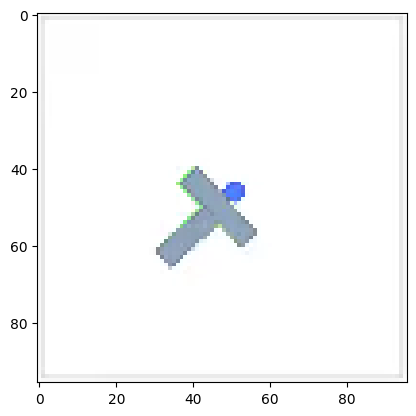

In [15]:
plt.imshow(goal["pixels"])